<a href="https://colab.research.google.com/github/mistrysontu/New/blob/new_branch/VS2_20CS60R15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Upload csv data to colab

In [ ]:
from google.colab import files
uploaded = files.upload()

## 0.1. Import libraries


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#1. K-means clustering

## 1.1 Read data

In [ ]:
df = pd.read_csv('virus_2_unlabelled.csv')
df.drop(df.columns[0], axis=1, inplace=True)

## 1.2 Normalize dataset using Z-Score Normalization


In [ ]:
mean_list = df.mean(axis=0)
std_list = df.std(axis=0, ddof=0)
for col_name in df.columns.values:
  df[col_name] = (df[col_name] - mean_list[col_name]) / std_list[col_name]

### Data set has some outliers, lets visualize them

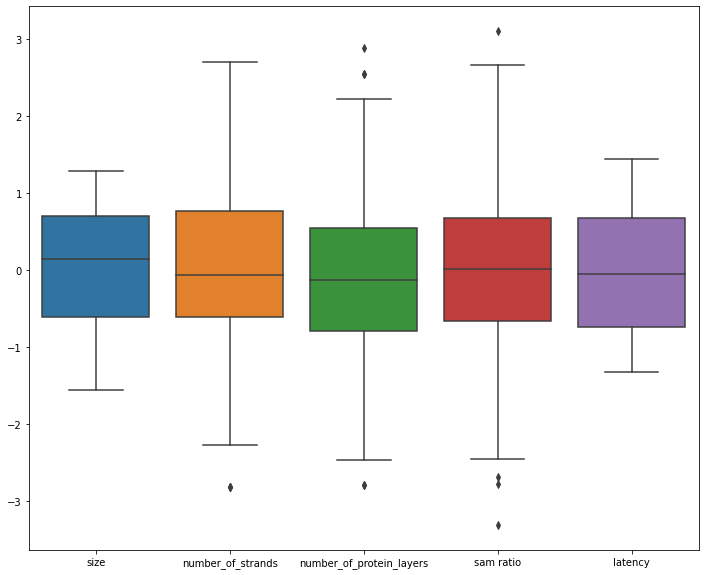

In [ ]:
plt.figure(figsize=(12,10))
sns.boxplot(data=df)
plt.show()

## 1.3 Remove outliers
N.B: If you want to know how the algorithm is working on the whole dataset then don't run the next cell

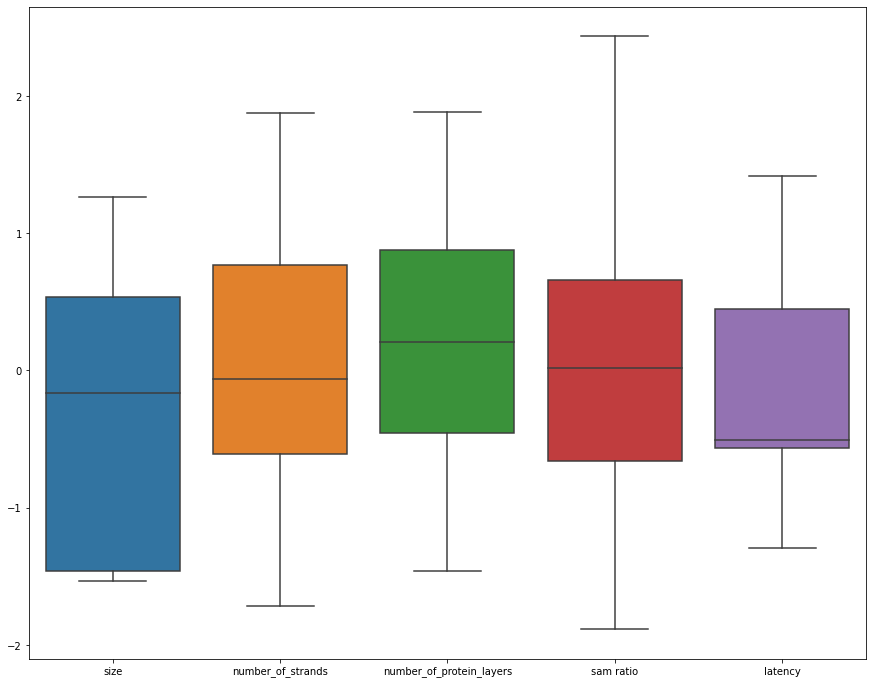

In [ ]:
upper_limit = df.quantile(.99)
lower_limit = df.quantile(.02)
df1 = df[(df <= upper_limit) & (df >= lower_limit)]
df = df1.dropna()
plt.figure(figsize=(15,12))
sns.boxplot(data=df2)
plt.show()

## 1.4 Define k-means algo


In [ ]:
def uclid_dist(x, y):
    # return np.sqrt(np.sum(np.square(np.square(x-y))))
    return np.linalg.norm(x-y)

def k_mean(df, ittr = 20, k=3, op=True):
    import time
    start = time.time()
    centroids = df.sample(n=k, random_state=0)
    for itr in range(ittr):
        cluster_list = [[] for _ in range(k)]
        cluster_points = [[] for _ in range(k)]
        # for all the points (row of df) find which cluster it should belongs to
        for i in range(len(df)):
            nearest_centroid = -1
            min_dist = 10e30
            # check which cluster is the nearest
            for j in range(len(centroids)):
                if(uclid_dist(centroids.iloc[j], df.iloc[i]) < min_dist):
                    min_dist = uclid_dist(centroids.iloc[j], df.iloc[i])
                    nearest_centroid = j

            # Add the point_i to the right cluster
            cluster_points[nearest_centroid].append(df.iloc[i])
            cluster_list[nearest_centroid].append(i)

        # Calculate new updated centroids
        for i in range(k):
            temp_df = pd.DataFrame(cluster_points[i])
            centroids.iloc[i] = temp_df.mean(axis=0)

        if op == True:
            print("epoch: ", itr+1)

    end = time.time()
    print('kmean algo took ', end - start, ' sec to execute.')    
    return centroids, cluster_points, cluster_list


## 1.5 Run kmeans algo


In [ ]:
centroids, cluster_point, cluster_list = k_mean(df, ittr = 20, k=3, op=True)
no_of_elements = [len(i) for i in cluster_list]
print()
print(len(cluster_list), 'clusters are created, with each cluster having', no_of_elements, 'elements')

epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
kmean algo took  17.030090808868408  sec to execute.

3 clusters are created, with each cluster having [106, 121, 216] elements


#2. Evaluation of the clustering algorithm


## 2.1 Define Silhouetee coefficient

In [ ]:
# for each cluster calculate a[i] and b[i] for all the point i belong to that cluster.
# find Silhouette_coefficient = (b[i] - a[i])/ max(b[i], a[i]) for all the points
# calculate final silhouette coeeficient as average of Silhouette_coefficient of all points.
def Silhouette_coefficient(cluster_list):
    # Create a list containing k (same as len(cluster_list)) number of empty list
    list_a = [[] for _ in range(len(cluster_list))] 
    list_b = [[] for _ in range(len(cluster_list))]
    ind = 0
    for cluster_i in cluster_list:
        for point in cluster_i:
            temp_a = list()
            temp_avg_b = None
            # FInd a[i] for all points
            for otr_pnt_in_clstr_i in cluster_i:
                temp_a.append(uclid_dist(point, otr_pnt_in_clstr_i))
            avg_a_for_point_i = sum(temp_a)/(len(temp_a)-1) # 1 less becouse we done't want to count itself.
                                                        # the point itself doesn't hurn the sum as distance from itself is zero.
            # store the a[i] value in list_a
            list_a[ind].append(avg_a_for_point_i)
        
            # find b[i] for all points
            remaining_cluster_list = list(filter(lambda x: x != cluster_i , cluster_list))
            # print((remaining_cluster_list[0]))
            for single_remaining_cluster in remaining_cluster_list:
                temp_b = list()
                for point_in_neighbour_cluster in single_remaining_cluster:
                    temp_b.append(uclid_dist(point, point_in_neighbour_cluster))
                # Calculate b[i] with respect to one neighbour cluster
                curr_avg_b_for_point_i = sum(temp_b)/len(temp_b)
                # Update global min b[i]
                if temp_avg_b == None or curr_avg_b_for_point_i < temp_avg_b:
                    temp_avg_b = curr_avg_b_for_point_i
            
            # store the optimal b[i] value in list_b
            list_b[ind].append(temp_avg_b)

        # next cluster
        ind += 1

    # Find Silhouette_coefficient for all points
    silhouette_coeff = list()
   
    '''
        list_a = list of 'k' lists
        list_b = list of 'k' lists
    '''
    for a_i, b_i in zip(list_a, list_b):
        for point_in_ai, point_in_bi in zip(a_i, b_i):
            slh_coeff = (point_in_bi - point_in_ai) / max(point_in_ai, point_in_bi)
            silhouette_coeff.append(slh_coeff)
    
    # Find mean silhouetee coefficient.
    mean_silhouette_coeff = sum(silhouette_coeff)/ len(silhouette_coeff)
    return mean_silhouette_coeff

## 2.2 Find Silhouette coeffecient

In [ ]:
import time
start = time.time()
print('Executing...')
print('It may take some while, please wait...')
mean_sc = Silhouette_coefficient(cluster_point)
print('Silhouetee coefficient:', mean_sc)
end = time.time()
print("Execution done in ", end - start, " sec.")
print(mean_sc)

Executing...
It may take some while, please wait...
Silhouetee coefficient: 0.3365216800869869
Execution done in  32.43312454223633  sec.
0.3365216800869869


# 3. Optimal value of k

In [ ]:
def optimal_k(df, k_list= [4, 5, 6] ):
    opt_sc = None
    opt_k = None

    print('Finding optimal value of k, please wait...')

    for i in k_list:
        centroids, cluster_point, cluster_list = k_mean(df, ittr = 20, k=i, op=False)
        mean_sc = Silhouette_coefficient(cluster_point)
        if opt_sc == None or mean_sc > opt_sc:
            opt_sc = mean_sc
            opt_k = i

        print('\nSilhoutee coefficient for k =', i, " :", mean_sc)

    print("\nOptimal k value is ", opt_k, ' with mean silhouette_coefficient is ', opt_sc)
    return opt_k


In [ ]:
opt_k = optimal_k(df)

Finding optimal value of k, please wait...
kmean algo took  19.66455078125  sec to execute.

Silhoutee coefficient for k = 4  : 0.35032468546328926
kmean algo took  22.238701105117798  sec to execute.

Silhoutee coefficient for k = 5  : 0.3176879255175736
kmean algo took  25.52617073059082  sec to execute.

Silhoutee coefficient for k = 6  : 0.2998562399853322

Optimal k value is  4  with mean silhouette_coefficient is  0.35032468546328926


# 4. Hierarchical Clustering

## 4.1. Create a len(df) x len(df) numpy array containing distance between each individual points.
N.B. Distance between (a, a) is set to inf

In [ ]:
import math 
inf = math.inf
import time
start = time.time()
print('Execution started...')
print('This may take a while, please wait...')

my_list = [[uclid_dist(df.iloc[j], df.iloc[i]) for i in range(len(df))] for j in range(len(df))]

# Update distance from one point to itself invalid (inf)
for i in range(len(df)):
    my_list[i][i] = inf

np_list = np.array(my_list)

end = time.time()
print("Execution done in ", end - start, " sec.")

Execution started...
This may take a while, please wait...
Execution done in  65.67050838470459  sec.


##4.2 Create the dendrogram

In [ ]:
import math
inf = math.inf
def dendron(np_list, k=4, op=True):
    if k <= 0:
        print("Error! number of clusters can't be less than 1")
        sys.exit()

    min_val = inf
    row, col = None, None
    N = np_list.shape[0]
    k_clusters = [[i] for i in range(N)] # e.g. [[0, 2, 6, 7], [1, 4],, ... [499]]
    dendrogram = [i for i in range(N)] # e.g. [(1,4), ((2, 6), 7) ]

    start = time.time()

    # contract the n distinct data points (or clusters, as a point is considered a cluster initially) to k clusters.
    # So, we need to contract n-k times.
    for p in range(N-k): # club 'N' clusters in k cluster
        dim = np_list.shape[0]
        if op == True:
            print('number of clusters till now:', dim-1)

        # Find the cell (in 2D matrix) with minimum value (minimum distanced points)
        for i in range(dim):
            for j in range(dim):
                if np_list[i][j] <= min_val:
                    min_val = np_list[i][j]
                    row, col = i, j

        np_list[row][col] = inf
        np_list[col][row] = inf
        min_val = inf

        # Find pair-wise minimum of two rows to be deleted (in row direction)
        z = np.minimum(np_list[row, :], np_list[col, :])
        # Delete the two rows
        np_list = np.delete(np_list, [row, col], axis=0)
        # Insert the pair-wise minumum row
        np_list = np.insert(np_list, min(row, col), z, axis=0)
        # Find pair-wise minimum of two columns to be deleted 
        z = np.minimum(np_list[:, row], np_list[:, col])
        # Delete the two columns
        np_list = np.delete(np_list, [row, col], axis=1)
        # Insert the pair-wise minumum columns
        np_list = np.insert(np_list, min(row, col), z, axis=1)
        
        # Update dendrogram matrix
        b = dendrogram.pop(max(row, col))
        a = dendrogram.pop(min(row, col))
        dendrogram.insert(min(row, col), (a,b))

        # Update cluster list
        b = k_clusters.pop(max(row, col))
        a = k_clusters.pop(min(row, col))
        a.extend(b)
        
        k_clusters.insert(min(row, col), a)

    # print('dendrogram: ', dendrogram)    
    # print()
    end = time.time()
    print("Execution done in ", end - start, " sec.")
    return dendrogram, k_clusters



## 4.4 Create clusters using hierarchical and kmeans algorithm

In [ ]:
print('\nExecuting Hierarchical algorithm please wait...')
dendrogram, k_clusters_hierarchical = dendron(np_list, k=opt_k, op=False)
print('\nExecuting kmeans algorithm please wait...')
centroids ,_, cluster_list = k_mean(df, ittr = 20, k=opt_k, op=False)


Executing Hierarchical algorithm please wait...
Execution done in  11.908713102340698  sec.

Executing kmeans algorithm please wait...
kmean algo took  19.686060428619385  sec to execute.


In [ ]:
print('Using kmeans...')
for i in range(opt_k):
    print(len(cluster_list[i]))
print()

print('Using hierarchical...')
for i in range(opt_k):
    print(len(k_clusters_hierarchical[i]))


Using kmeans...
106
120
109
108

Using hierarchical...
109
121
108
105


## 4.3 Jaccard Similarity

In [ ]:
def jaccard(a, b):
    a = set(a)
    b = set(b)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


In [ ]:
cluster_list, k_clusters_hierarchical
row1, row2
i = 0
for row1 in cluster_list:
    i += 1
    j = 0
    k
    temp = -1
    for row2 in k_clusters_hierarchical:
        j += 1
        # k = set(i)
        row1 = list(row1)
        col = list(row2)
        x = jaccard(row1, row2)
        if(x > temp):
            temp = x
            k = j
    
    print('Similarity between: ', i, 'and', k, 'is', temp)



Similarity between:  1 and 4 is 0.9719626168224299
Similarity between:  2 and 2 is 0.9754098360655737
Similarity between:  3 and 1 is 0.9464285714285714
Similarity between:  4 and 3 is 0.9459459459459459


In [ ]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# from matplotlib import pyplot as plt

# linked = linkage(df.values.tolist(), 'single')

# # labelList = range(1, 11)

# plt.figure(figsize=(15, 15))
# dendrogram(linked,
#             orientation='top',
#             distance_sort='descending',
#             show_leaf_counts=True)
# plt.show()

#Sklearn

In [ ]:
# def preprocess():
#     data = pd.read_csv("virus_2_unlabelled.csv", index_col = 0)
#     d = np.array(data).astype(float)
#     for i in range(len(d[0])):
#         d[:, i] = (d[:, i]-np.mean(d[:, i]))/np.std(d[:, i])    
#     return d

# import pandas as pd
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import numpy as np

# X = preprocess()

# kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
# centres_ = kmeans.cluster_centers_
# print(centres_)
# print()
# print(centroids)
# score = silhouette_score(X, kmeans.labels_, metric='euclidean')
# print(score)